# Image Captioning with Attention

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
tf.enable_eager_execution(config)

# from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

# import re
import numpy as np
# import os
# import time
# import json
# from glob import glob
from PIL import Image
# import pickle
from DataDownloader.mscocodownloader import MSCocoDownloader
from Models.inceptionmodel import InceptionModel
from Utils.visualiser import Visualiser
from DatasetGeneration.datasetgeneratornolabels import DatasetGeneratorNoLabels
from DatasetGeneration.datasetgenerator import DatasetGenerator
from Models.attentionmodel import AttentionModel
from Models.Helpers.tokenisations import Tokenisations

D:\IDEs\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Preparing the Data Download

In [3]:
# Sample Count - number of images used to train and validatate the model, set to be None to include the whole dataset
sample_count = 8000

In [4]:
mscoco = MSCocoDownloader(sample_count)

In [5]:
mscoco.image_name_vector[0:5]

['D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000324909.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000511972.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000508809.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000270497.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000008014.jpg']

In [6]:
mscoco.train_captions[0:5]

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>']

## 2. Visualising the Data (Optional)

In [7]:
vis = Visualiser()

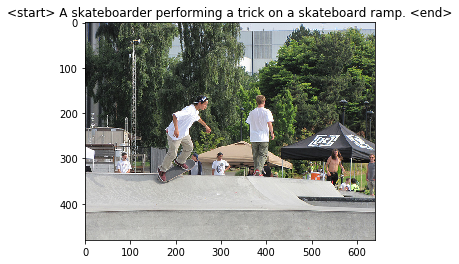

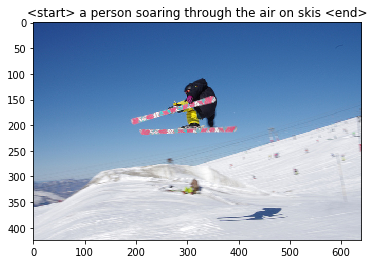

In [8]:
vis.show_image(mscoco.image_name_vector[0],mscoco.train_captions[0])
vis.show_image(mscoco.image_name_vector[1],mscoco.train_captions[1])

## 3. Faster Training by Processing Images through Inception V3

In [9]:
encode_train = sorted(set(mscoco.image_name_vector))
inmodel = InceptionModel()
datasetGeneratorNoLabels = DatasetGeneratorNoLabels(encode_train)

In [10]:
inmodel.cache_to_numpy_files_forward_pass(datasetGeneratorNoLabels.dataset)

598it [15:37,  1.53s/it]


## 4. Preprocess and tokenize the captions

In [10]:
tokenisations = Tokenisations()

In [11]:
tokenisations.prepare_training_tokens(mscoco.train_captions)
tokenisations.save_tokeniser()

## 5. Split Training and Testing

In [12]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(mscoco.image_name_vector, 
                                                                    tokenisations.cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [13]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(6400, 6400, 1600, 1600)

## 6. Dataset Generator from Inception Output 

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenisations.tokenizer.word_index)

attention_features_shape = 64

## 7. Model Creation

In [15]:
attentionModel = AttentionModel(tokenisations, embedding_dim, units, vocab_size, BATCH_SIZE, attention_features_shape, inmodel.image_features_extract_model)

In [16]:
datasetGenerator = DatasetGenerator(img_name_train, cap_train, BATCH_SIZE, BUFFER_SIZE)

## 8. Training

In [23]:
attentionModel.train(datasetGenerator.dataset, 10)


0it [00:00, ?it/s]
Processing 0: tf.Tensor(43.98247, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 1 Batch 0 Loss 0.8976



Processing 0: tf.Tensor(43.98247, shape=(), dtype=float32): : 1it [00:47, 47.96s/it]
Processing 1: tf.Tensor(45.363983, shape=(), dtype=float32): : 1it [00:49, 49.26s/it]
Processing 1: tf.Tensor(45.363983, shape=(), dtype=float32): : 2it [00:51, 25.93s/it]
Processing 2: tf.Tensor(43.14588, shape=(), dtype=float32): : 2it [00:53, 26.62s/it] 
Processing 2: tf.Tensor(43.14588, shape=(), dtype=float32): : 3it [00:55, 18.60s/it]
Processing 3: tf.Tensor(47.1356, shape=(), dtype=float32): : 3it [00:57, 19.01s/it] 
Processing 3: tf.Tensor(47.1356, shape=(), dtype=float32): : 4it [00:59, 14.90s/it]
Processing 4: tf.Tensor(50.167156, shape=(), dtype=float32): : 4it [01:01, 15.30s/it]
Processing 4: tf.Tensor(50.167156, shape=(), dtype=float32): : 5it [01:03, 12.74s/it]
Processing 5: tf.Tensor(47.738556, shape=(), dtype=float32): : 5it [01:05, 13.02s/it]
Processing 5: tf.Tensor(47.738556, shape=(), dtype=float32): : 6it [01:07, 11.32s/it]
Processing 6: tf.Tensor(45.726807, shape=(), dtype=float32

Epoch 1 Batch 20 Loss 0.9545



Processing 20: tf.Tensor(46.770077, shape=(), dtype=float32): : 21it [02:14,  6.42s/it]
Processing 21: tf.Tensor(48.07108, shape=(), dtype=float32): : 21it [02:16,  6.48s/it] 
Processing 21: tf.Tensor(48.07108, shape=(), dtype=float32): : 22it [02:18,  6.31s/it]
Processing 22: tf.Tensor(44.338825, shape=(), dtype=float32): : 22it [02:20,  6.39s/it]
Processing 22: tf.Tensor(44.338825, shape=(), dtype=float32): : 23it [02:23,  6.23s/it]
Processing 23: tf.Tensor(45.626114, shape=(), dtype=float32): : 23it [02:24,  6.29s/it]
Processing 23: tf.Tensor(45.626114, shape=(), dtype=float32): : 24it [02:28,  6.17s/it]
Processing 24: tf.Tensor(43.956913, shape=(), dtype=float32): : 24it [02:30,  6.25s/it]
Processing 24: tf.Tensor(43.956913, shape=(), dtype=float32): : 25it [02:33,  6.13s/it]
Processing 25: tf.Tensor(43.609516, shape=(), dtype=float32): : 25it [02:34,  6.18s/it]
Processing 25: tf.Tensor(43.609516, shape=(), dtype=float32): : 26it [02:37,  6.08s/it]
Processing 26: tf.Tensor(44.2453

Epoch 1 Batch 40 Loss 0.9104



Processing 40: tf.Tensor(44.610226, shape=(), dtype=float32): : 41it [03:54,  5.73s/it]
Processing 41: tf.Tensor(45.612366, shape=(), dtype=float32): : 41it [03:56,  5.76s/it]
Processing 41: tf.Tensor(45.612366, shape=(), dtype=float32): : 42it [04:00,  5.73s/it]
Processing 42: tf.Tensor(42.49866, shape=(), dtype=float32): : 42it [04:02,  5.76s/it] 
Processing 42: tf.Tensor(42.49866, shape=(), dtype=float32): : 43it [04:06,  5.74s/it]
Processing 43: tf.Tensor(38.96699, shape=(), dtype=float32): : 43it [04:09,  5.80s/it]
Processing 43: tf.Tensor(38.96699, shape=(), dtype=float32): : 44it [04:13,  5.75s/it]
Processing 44: tf.Tensor(40.947952, shape=(), dtype=float32): : 44it [04:14,  5.78s/it]
Processing 44: tf.Tensor(40.947952, shape=(), dtype=float32): : 45it [04:19,  5.76s/it]
Processing 45: tf.Tensor(43.235508, shape=(), dtype=float32): : 45it [04:21,  5.81s/it]
Processing 45: tf.Tensor(43.235508, shape=(), dtype=float32): : 46it [04:24,  5.75s/it]
Processing 46: tf.Tensor(42.58862,

Epoch 1 Batch 60 Loss 0.8327



Processing 60: tf.Tensor(40.800873, shape=(), dtype=float32): : 61it [05:48,  5.71s/it]
Processing 61: tf.Tensor(46.12223, shape=(), dtype=float32): : 61it [05:50,  5.75s/it] 
Processing 61: tf.Tensor(46.12223, shape=(), dtype=float32): : 62it [05:55,  5.73s/it]
Processing 62: tf.Tensor(44.90929, shape=(), dtype=float32): : 62it [05:57,  5.77s/it]
Processing 62: tf.Tensor(44.90929, shape=(), dtype=float32): : 63it [06:01,  5.73s/it]
Processing 63: tf.Tensor(42.81469, shape=(), dtype=float32): : 63it [06:03,  5.77s/it]
Processing 63: tf.Tensor(42.81469, shape=(), dtype=float32): : 64it [06:05,  5.71s/it]
Processing 64: tf.Tensor(42.24498, shape=(), dtype=float32): : 64it [06:06,  5.73s/it]
Processing 64: tf.Tensor(42.24498, shape=(), dtype=float32): : 65it [06:12,  5.73s/it]
Processing 65: tf.Tensor(44.05482, shape=(), dtype=float32): : 65it [06:13,  5.75s/it]
Processing 65: tf.Tensor(44.05482, shape=(), dtype=float32): : 66it [06:16,  5.71s/it]
Processing 66: tf.Tensor(41.997597, shap

Epoch 1 Batch 80 Loss 0.8976



Processing 80: tf.Tensor(43.984722, shape=(), dtype=float32): : 81it [07:58,  5.91s/it]
Processing 81: tf.Tensor(40.8552, shape=(), dtype=float32): : 81it [08:02,  5.95s/it]  
Processing 81: tf.Tensor(40.8552, shape=(), dtype=float32): : 82it [08:04,  5.91s/it]
Processing 82: tf.Tensor(43.322918, shape=(), dtype=float32): : 82it [08:05,  5.92s/it]
Processing 82: tf.Tensor(43.322918, shape=(), dtype=float32): : 83it [08:10,  5.92s/it]
Processing 83: tf.Tensor(41.0276, shape=(), dtype=float32): : 83it [08:12,  5.93s/it]  
Processing 83: tf.Tensor(41.0276, shape=(), dtype=float32): : 84it [08:15,  5.90s/it]
Processing 84: tf.Tensor(38.105297, shape=(), dtype=float32): : 84it [08:16,  5.91s/it]
Processing 84: tf.Tensor(38.105297, shape=(), dtype=float32): : 85it [08:20,  5.88s/it]
Processing 85: tf.Tensor(44.261753, shape=(), dtype=float32): : 85it [08:20,  5.89s/it]
Processing 85: tf.Tensor(44.261753, shape=(), dtype=float32): : 86it [08:25,  5.87s/it]
Processing 86: tf.Tensor(42.133034,

Epoch 1 Loss 0.014008
Time taken for 1 epoch 558.6578841209412 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(40.142937, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 2 Batch 0 Loss 0.8192



Processing 0: tf.Tensor(40.142937, shape=(), dtype=float32): : 1it [00:49, 49.65s/it]
Processing 1: tf.Tensor(38.68485, shape=(), dtype=float32): : 1it [00:52, 52.71s/it] 
Processing 1: tf.Tensor(38.68485, shape=(), dtype=float32): : 2it [00:55, 27.91s/it]
Processing 2: tf.Tensor(40.81609, shape=(), dtype=float32): : 2it [00:59, 29.53s/it]
Processing 2: tf.Tensor(40.81609, shape=(), dtype=float32): : 3it [01:03, 21.04s/it]
Processing 3: tf.Tensor(39.431404, shape=(), dtype=float32): : 3it [01:08, 22.99s/it]
Processing 3: tf.Tensor(39.431404, shape=(), dtype=float32): : 4it [01:14, 18.69s/it]
Processing 4: tf.Tensor(38.85146, shape=(), dtype=float32): : 4it [01:20, 20.04s/it] 
Processing 4: tf.Tensor(38.85146, shape=(), dtype=float32): : 5it [01:23, 16.74s/it]
Processing 5: tf.Tensor(43.13879, shape=(), dtype=float32): : 5it [01:25, 17.05s/it]
Processing 5: tf.Tensor(43.13879, shape=(), dtype=float32): : 6it [01:28, 14.71s/it]
Processing 6: tf.Tensor(40.864735, shape=(), dtype=float32)

Epoch 2 Batch 20 Loss 0.8529



Processing 20: tf.Tensor(41.79039, shape=(), dtype=float32): : 21it [02:43,  7.81s/it]
Processing 21: tf.Tensor(39.650993, shape=(), dtype=float32): : 21it [02:47,  7.97s/it]
Processing 21: tf.Tensor(39.650993, shape=(), dtype=float32): : 22it [02:52,  7.85s/it]
Processing 22: tf.Tensor(40.1824, shape=(), dtype=float32): : 22it [02:57,  8.09s/it]  
Processing 22: tf.Tensor(40.1824, shape=(), dtype=float32): : 23it [03:01,  7.88s/it]
Processing 23: tf.Tensor(39.045036, shape=(), dtype=float32): : 23it [03:03,  7.98s/it]
Processing 23: tf.Tensor(39.045036, shape=(), dtype=float32): : 24it [03:06,  7.78s/it]
Processing 24: tf.Tensor(42.139973, shape=(), dtype=float32): : 24it [03:08,  7.85s/it]
Processing 24: tf.Tensor(42.139973, shape=(), dtype=float32): : 25it [03:11,  7.67s/it]
Processing 25: tf.Tensor(41.204945, shape=(), dtype=float32): : 25it [03:14,  7.80s/it]
Processing 25: tf.Tensor(41.204945, shape=(), dtype=float32): : 26it [03:17,  7.61s/it]
Processing 26: tf.Tensor(39.398136

Epoch 2 Batch 40 Loss 0.8478



Processing 40: tf.Tensor(41.543484, shape=(), dtype=float32): : 41it [04:43,  6.91s/it]
Processing 41: tf.Tensor(39.68096, shape=(), dtype=float32): : 41it [04:45,  6.96s/it] 
Processing 41: tf.Tensor(39.68096, shape=(), dtype=float32): : 42it [04:48,  6.87s/it]
Processing 42: tf.Tensor(39.68943, shape=(), dtype=float32): : 42it [04:51,  6.93s/it]
Processing 42: tf.Tensor(39.68943, shape=(), dtype=float32): : 43it [04:54,  6.84s/it]
Processing 43: tf.Tensor(39.214184, shape=(), dtype=float32): : 43it [04:55,  6.88s/it]
Processing 43: tf.Tensor(39.214184, shape=(), dtype=float32): : 44it [04:58,  6.79s/it]
Processing 44: tf.Tensor(40.94608, shape=(), dtype=float32): : 44it [05:02,  6.86s/it] 
Processing 44: tf.Tensor(40.94608, shape=(), dtype=float32): : 45it [05:05,  6.78s/it]
Processing 45: tf.Tensor(35.851574, shape=(), dtype=float32): : 45it [05:06,  6.82s/it]
Processing 45: tf.Tensor(35.851574, shape=(), dtype=float32): : 46it [05:09,  6.74s/it]
Processing 46: tf.Tensor(38.4487, s

Epoch 2 Batch 60 Loss 0.8292



Processing 60: tf.Tensor(40.628654, shape=(), dtype=float32): : 61it [06:41,  6.58s/it]
Processing 61: tf.Tensor(41.26518, shape=(), dtype=float32): : 61it [06:42,  6.60s/it] 
Processing 61: tf.Tensor(41.26518, shape=(), dtype=float32): : 62it [06:45,  6.53s/it]
Processing 62: tf.Tensor(40.59168, shape=(), dtype=float32): : 62it [06:46,  6.56s/it]
Processing 62: tf.Tensor(40.59168, shape=(), dtype=float32): : 63it [06:51,  6.53s/it]
Processing 63: tf.Tensor(40.942616, shape=(), dtype=float32): : 63it [06:54,  6.58s/it]
Processing 63: tf.Tensor(40.942616, shape=(), dtype=float32): : 64it [06:58,  6.55s/it]
Processing 64: tf.Tensor(41.691, shape=(), dtype=float32): : 64it [07:03,  6.62s/it]   
Processing 64: tf.Tensor(41.691, shape=(), dtype=float32): : 65it [07:08,  6.60s/it]
Processing 65: tf.Tensor(40.63594, shape=(), dtype=float32): : 65it [07:15,  6.70s/it]
Processing 65: tf.Tensor(40.63594, shape=(), dtype=float32): : 66it [07:19,  6.66s/it]
Processing 66: tf.Tensor(40.53884, shap

Epoch 2 Batch 80 Loss 0.7721



Processing 80: tf.Tensor(37.83432, shape=(), dtype=float32): : 81it [08:59,  6.66s/it]
Processing 81: tf.Tensor(38.794697, shape=(), dtype=float32): : 81it [09:00,  6.68s/it]
Processing 81: tf.Tensor(38.794697, shape=(), dtype=float32): : 82it [09:03,  6.63s/it]
Processing 82: tf.Tensor(40.51331, shape=(), dtype=float32): : 82it [09:05,  6.65s/it] 
Processing 82: tf.Tensor(40.51331, shape=(), dtype=float32): : 83it [09:11,  6.65s/it]
Processing 83: tf.Tensor(37.784237, shape=(), dtype=float32): : 83it [09:17,  6.71s/it]
Processing 83: tf.Tensor(37.784237, shape=(), dtype=float32): : 84it [09:20,  6.67s/it]
Processing 84: tf.Tensor(41.02328, shape=(), dtype=float32): : 84it [09:21,  6.68s/it] 
Processing 84: tf.Tensor(41.02328, shape=(), dtype=float32): : 85it [09:24,  6.64s/it]
Processing 85: tf.Tensor(36.501785, shape=(), dtype=float32): : 85it [09:25,  6.65s/it]
Processing 85: tf.Tensor(36.501785, shape=(), dtype=float32): : 86it [09:28,  6.61s/it]
Processing 86: tf.Tensor(35.1572, 

Epoch 2 Loss 0.012767
Time taken for 1 epoch 618.1909193992615 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(34.4401, shape=(), dtype=float32): : 0it [00:44, ?it/s]

Epoch 3 Batch 0 Loss 0.7029



Processing 0: tf.Tensor(34.4401, shape=(), dtype=float32): : 1it [00:49, 49.00s/it]
Processing 1: tf.Tensor(38.008842, shape=(), dtype=float32): : 1it [00:52, 52.28s/it]
Processing 1: tf.Tensor(38.008842, shape=(), dtype=float32): : 2it [00:55, 27.78s/it]
Processing 2: tf.Tensor(34.92012, shape=(), dtype=float32): : 2it [00:57, 28.90s/it] 
Processing 2: tf.Tensor(34.92012, shape=(), dtype=float32): : 3it [01:00, 20.13s/it]
Processing 3: tf.Tensor(38.494457, shape=(), dtype=float32): : 3it [01:03, 21.01s/it]
Processing 3: tf.Tensor(38.494457, shape=(), dtype=float32): : 4it [01:07, 16.87s/it]
Processing 4: tf.Tensor(35.794273, shape=(), dtype=float32): : 4it [01:09, 17.46s/it]
Processing 4: tf.Tensor(35.794273, shape=(), dtype=float32): : 5it [01:15, 15.07s/it]
Processing 5: tf.Tensor(36.38448, shape=(), dtype=float32): : 5it [01:17, 15.51s/it] 
Processing 5: tf.Tensor(36.38448, shape=(), dtype=float32): : 6it [01:21, 13.62s/it]
Processing 6: tf.Tensor(38.25791, shape=(), dtype=float32

Epoch 3 Batch 20 Loss 0.7453



Processing 20: tf.Tensor(36.521397, shape=(), dtype=float32): : 21it [03:09,  9.01s/it]
Processing 21: tf.Tensor(37.64825, shape=(), dtype=float32): : 21it [03:10,  9.08s/it] 
Processing 21: tf.Tensor(37.64825, shape=(), dtype=float32): : 22it [03:14,  8.85s/it]
Processing 22: tf.Tensor(36.329422, shape=(), dtype=float32): : 22it [03:17,  8.96s/it]
Processing 22: tf.Tensor(36.329422, shape=(), dtype=float32): : 23it [03:19,  8.68s/it]
Processing 23: tf.Tensor(38.284172, shape=(), dtype=float32): : 23it [03:21,  8.75s/it]
Processing 23: tf.Tensor(38.284172, shape=(), dtype=float32): : 24it [03:24,  8.53s/it]
Processing 24: tf.Tensor(35.738483, shape=(), dtype=float32): : 24it [03:25,  8.58s/it]
Processing 24: tf.Tensor(35.738483, shape=(), dtype=float32): : 25it [03:29,  8.37s/it]
Processing 25: tf.Tensor(38.687225, shape=(), dtype=float32): : 25it [03:32,  8.48s/it]
Processing 25: tf.Tensor(38.687225, shape=(), dtype=float32): : 26it [03:35,  8.28s/it]
Processing 26: tf.Tensor(36.1965

Epoch 3 Batch 40 Loss 0.7603



Processing 40: tf.Tensor(37.256924, shape=(), dtype=float32): : 41it [05:06,  7.47s/it]
Processing 41: tf.Tensor(38.11246, shape=(), dtype=float32): : 41it [05:07,  7.50s/it] 
Processing 41: tf.Tensor(38.11246, shape=(), dtype=float32): : 42it [05:10,  7.39s/it]
Processing 42: tf.Tensor(35.481686, shape=(), dtype=float32): : 42it [05:11,  7.42s/it]
Processing 42: tf.Tensor(35.481686, shape=(), dtype=float32): : 43it [05:15,  7.33s/it]
Processing 43: tf.Tensor(38.08627, shape=(), dtype=float32): : 43it [05:17,  7.39s/it] 
Processing 43: tf.Tensor(38.08627, shape=(), dtype=float32): : 44it [05:20,  7.29s/it]
Processing 44: tf.Tensor(37.771366, shape=(), dtype=float32): : 44it [05:22,  7.32s/it]
Processing 44: tf.Tensor(37.771366, shape=(), dtype=float32): : 45it [05:25,  7.24s/it]
Processing 45: tf.Tensor(38.244045, shape=(), dtype=float32): : 45it [05:28,  7.29s/it]
Processing 45: tf.Tensor(38.244045, shape=(), dtype=float32): : 46it [05:31,  7.20s/it]
Processing 46: tf.Tensor(34.98372

Epoch 3 Batch 60 Loss 0.7632



Processing 60: tf.Tensor(37.39639, shape=(), dtype=float32): : 61it [06:55,  6.80s/it]
Processing 61: tf.Tensor(36.470516, shape=(), dtype=float32): : 61it [06:57,  6.84s/it]
Processing 61: tf.Tensor(36.470516, shape=(), dtype=float32): : 62it [07:02,  6.81s/it]
Processing 62: tf.Tensor(37.963898, shape=(), dtype=float32): : 62it [07:04,  6.85s/it]
Processing 62: tf.Tensor(37.963898, shape=(), dtype=float32): : 63it [07:08,  6.80s/it]
Processing 63: tf.Tensor(37.206516, shape=(), dtype=float32): : 63it [07:10,  6.84s/it]
Processing 63: tf.Tensor(37.206516, shape=(), dtype=float32): : 64it [07:13,  6.77s/it]
Processing 64: tf.Tensor(36.347107, shape=(), dtype=float32): : 64it [07:14,  6.80s/it]
Processing 64: tf.Tensor(36.347107, shape=(), dtype=float32): : 65it [07:18,  6.75s/it]
Processing 65: tf.Tensor(37.63378, shape=(), dtype=float32): : 65it [07:20,  6.78s/it] 
Processing 65: tf.Tensor(37.63378, shape=(), dtype=float32): : 66it [07:23,  6.72s/it]
Processing 66: tf.Tensor(36.52742

Epoch 3 Batch 80 Loss 0.7260



Processing 80: tf.Tensor(35.57435, shape=(), dtype=float32): : 81it [09:05,  6.73s/it]
Processing 81: tf.Tensor(35.767624, shape=(), dtype=float32): : 81it [09:07,  6.76s/it]
Processing 81: tf.Tensor(35.767624, shape=(), dtype=float32): : 82it [09:10,  6.71s/it]
Processing 82: tf.Tensor(36.500156, shape=(), dtype=float32): : 82it [09:11,  6.73s/it]
Processing 82: tf.Tensor(36.500156, shape=(), dtype=float32): : 83it [09:15,  6.70s/it]
Processing 83: tf.Tensor(37.225136, shape=(), dtype=float32): : 83it [09:17,  6.72s/it]
Processing 83: tf.Tensor(37.225136, shape=(), dtype=float32): : 84it [09:19,  6.66s/it]
Processing 84: tf.Tensor(33.26433, shape=(), dtype=float32): : 84it [09:20,  6.67s/it] 
Processing 84: tf.Tensor(33.26433, shape=(), dtype=float32): : 85it [09:22,  6.62s/it]
Processing 85: tf.Tensor(38.776882, shape=(), dtype=float32): : 85it [09:23,  6.62s/it]
Processing 85: tf.Tensor(38.776882, shape=(), dtype=float32): : 86it [09:25,  6.58s/it]
Processing 86: tf.Tensor(35.74625

Epoch 3 Loss 0.011895
Time taken for 1 epoch 618.0533890724182 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(34.591934, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 4 Batch 0 Loss 0.7060



Processing 0: tf.Tensor(34.591934, shape=(), dtype=float32): : 1it [00:50, 50.47s/it]
Processing 1: tf.Tensor(35.577736, shape=(), dtype=float32): : 1it [00:54, 54.65s/it]
Processing 1: tf.Tensor(35.577736, shape=(), dtype=float32): : 2it [00:58, 29.17s/it]
Processing 2: tf.Tensor(35.85457, shape=(), dtype=float32): : 2it [01:00, 30.31s/it] 
Processing 2: tf.Tensor(35.85457, shape=(), dtype=float32): : 3it [01:06, 22.00s/it]
Processing 3: tf.Tensor(32.170425, shape=(), dtype=float32): : 3it [01:10, 23.57s/it]
Processing 3: tf.Tensor(32.170425, shape=(), dtype=float32): : 4it [01:14, 18.61s/it]
Processing 4: tf.Tensor(37.136177, shape=(), dtype=float32): : 4it [01:17, 19.31s/it]
Processing 4: tf.Tensor(37.136177, shape=(), dtype=float32): : 5it [01:22, 16.51s/it]
Processing 5: tf.Tensor(33.61095, shape=(), dtype=float32): : 5it [01:24, 16.82s/it] 
Processing 5: tf.Tensor(33.61095, shape=(), dtype=float32): : 6it [01:28, 14.83s/it]
Processing 6: tf.Tensor(32.131252, shape=(), dtype=floa

Epoch 4 Batch 20 Loss 0.7024



Processing 20: tf.Tensor(34.416405, shape=(), dtype=float32): : 21it [02:57,  8.44s/it]
Processing 21: tf.Tensor(35.611465, shape=(), dtype=float32): : 21it [02:58,  8.50s/it]
Processing 21: tf.Tensor(35.611465, shape=(), dtype=float32): : 22it [03:02,  8.30s/it]
Processing 22: tf.Tensor(35.852585, shape=(), dtype=float32): : 22it [03:03,  8.36s/it]
Processing 22: tf.Tensor(35.852585, shape=(), dtype=float32): : 23it [03:07,  8.14s/it]
Processing 23: tf.Tensor(32.825325, shape=(), dtype=float32): : 23it [03:08,  8.21s/it]
Processing 23: tf.Tensor(32.825325, shape=(), dtype=float32): : 24it [03:13,  8.05s/it]
Processing 24: tf.Tensor(33.619236, shape=(), dtype=float32): : 24it [03:14,  8.11s/it]
Processing 24: tf.Tensor(33.619236, shape=(), dtype=float32): : 25it [03:17,  7.92s/it]
Processing 25: tf.Tensor(35.026604, shape=(), dtype=float32): : 25it [03:20,  8.01s/it]
Processing 25: tf.Tensor(35.026604, shape=(), dtype=float32): : 26it [03:23,  7.84s/it]
Processing 26: tf.Tensor(33.112

Epoch 4 Batch 40 Loss 0.7161



Processing 40: tf.Tensor(35.090664, shape=(), dtype=float32): : 41it [04:54,  7.18s/it]
Processing 41: tf.Tensor(34.92603, shape=(), dtype=float32): : 41it [04:56,  7.23s/it] 
Processing 41: tf.Tensor(34.92603, shape=(), dtype=float32): : 42it [04:58,  7.11s/it]
Processing 42: tf.Tensor(33.411602, shape=(), dtype=float32): : 42it [05:00,  7.15s/it]
Processing 42: tf.Tensor(33.411602, shape=(), dtype=float32): : 43it [05:03,  7.06s/it]
Processing 43: tf.Tensor(37.80815, shape=(), dtype=float32): : 43it [05:06,  7.12s/it] 
Processing 43: tf.Tensor(37.80815, shape=(), dtype=float32): : 44it [05:10,  7.06s/it]
Processing 44: tf.Tensor(31.910006, shape=(), dtype=float32): : 44it [05:12,  7.09s/it]
Processing 44: tf.Tensor(31.910006, shape=(), dtype=float32): : 45it [05:15,  7.02s/it]
Processing 45: tf.Tensor(33.417496, shape=(), dtype=float32): : 45it [05:18,  7.08s/it]
Processing 45: tf.Tensor(33.417496, shape=(), dtype=float32): : 46it [05:21,  7.00s/it]
Processing 46: tf.Tensor(32.98518

Epoch 4 Batch 60 Loss 0.6454



Processing 60: tf.Tensor(31.623304, shape=(), dtype=float32): : 61it [06:52,  6.76s/it]
Processing 61: tf.Tensor(33.068302, shape=(), dtype=float32): : 61it [06:54,  6.79s/it]
Processing 61: tf.Tensor(33.068302, shape=(), dtype=float32): : 62it [06:59,  6.76s/it]
Processing 62: tf.Tensor(34.87323, shape=(), dtype=float32): : 62it [07:01,  6.80s/it] 
Processing 62: tf.Tensor(34.87323, shape=(), dtype=float32): : 63it [07:03,  6.73s/it]
Processing 63: tf.Tensor(38.1294, shape=(), dtype=float32): : 63it [07:05,  6.75s/it] 
Processing 63: tf.Tensor(38.1294, shape=(), dtype=float32): : 64it [07:08,  6.69s/it]
Processing 64: tf.Tensor(34.394493, shape=(), dtype=float32): : 64it [07:10,  6.72s/it]
Processing 64: tf.Tensor(34.394493, shape=(), dtype=float32): : 65it [07:12,  6.66s/it]
Processing 65: tf.Tensor(33.42765, shape=(), dtype=float32): : 65it [07:14,  6.68s/it] 
Processing 65: tf.Tensor(33.42765, shape=(), dtype=float32): : 66it [07:18,  6.65s/it]
Processing 66: tf.Tensor(35.351864, 

Epoch 4 Batch 80 Loss 0.7128



Processing 80: tf.Tensor(34.929146, shape=(), dtype=float32): : 81it [08:48,  6.53s/it]
Processing 81: tf.Tensor(33.22734, shape=(), dtype=float32): : 81it [08:49,  6.54s/it] 
Processing 81: tf.Tensor(33.22734, shape=(), dtype=float32): : 82it [08:52,  6.49s/it]
Processing 82: tf.Tensor(32.657745, shape=(), dtype=float32): : 82it [08:53,  6.51s/it]
Processing 82: tf.Tensor(32.657745, shape=(), dtype=float32): : 83it [08:56,  6.47s/it]
Processing 83: tf.Tensor(34.30101, shape=(), dtype=float32): : 83it [09:00,  6.51s/it] 
Processing 83: tf.Tensor(34.30101, shape=(), dtype=float32): : 84it [09:03,  6.47s/it]
Processing 84: tf.Tensor(32.501274, shape=(), dtype=float32): : 84it [09:04,  6.48s/it]
Processing 84: tf.Tensor(32.501274, shape=(), dtype=float32): : 85it [09:08,  6.45s/it]
Processing 85: tf.Tensor(35.975094, shape=(), dtype=float32): : 85it [09:08,  6.46s/it]
Processing 85: tf.Tensor(35.975094, shape=(), dtype=float32): : 86it [09:11,  6.42s/it]
Processing 86: tf.Tensor(36.48636

Epoch 4 Loss 0.011157
Time taken for 1 epoch 603.1021082401276 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(31.036005, shape=(), dtype=float32): : 0it [00:44, ?it/s]

Epoch 5 Batch 0 Loss 0.6334



Processing 0: tf.Tensor(31.036005, shape=(), dtype=float32): : 1it [00:48, 48.62s/it]
Processing 1: tf.Tensor(31.717642, shape=(), dtype=float32): : 1it [00:51, 51.12s/it]
Processing 1: tf.Tensor(31.717642, shape=(), dtype=float32): : 2it [00:54, 27.12s/it]
Processing 2: tf.Tensor(31.642443, shape=(), dtype=float32): : 2it [00:56, 28.48s/it]
Processing 2: tf.Tensor(31.642443, shape=(), dtype=float32): : 3it [01:00, 20.17s/it]
Processing 3: tf.Tensor(30.187386, shape=(), dtype=float32): : 3it [01:03, 21.13s/it]
Processing 3: tf.Tensor(30.187386, shape=(), dtype=float32): : 4it [01:08, 17.02s/it]
Processing 4: tf.Tensor(33.166367, shape=(), dtype=float32): : 4it [01:12, 18.07s/it]
Processing 4: tf.Tensor(33.166367, shape=(), dtype=float32): : 5it [01:15, 15.19s/it]
Processing 5: tf.Tensor(33.199154, shape=(), dtype=float32): : 5it [01:18, 15.61s/it]
Processing 5: tf.Tensor(33.199154, shape=(), dtype=float32): : 6it [01:22, 13.69s/it]
Processing 6: tf.Tensor(32.38686, shape=(), dtype=flo

Epoch 5 Batch 20 Loss 0.6165



Processing 20: tf.Tensor(30.210394, shape=(), dtype=float32): : 21it [02:49,  8.09s/it]
Processing 21: tf.Tensor(31.668715, shape=(), dtype=float32): : 21it [02:52,  8.23s/it]
Processing 21: tf.Tensor(31.668715, shape=(), dtype=float32): : 22it [02:58,  8.12s/it]
Processing 22: tf.Tensor(32.77363, shape=(), dtype=float32): : 22it [03:00,  8.22s/it] 
Processing 22: tf.Tensor(32.77363, shape=(), dtype=float32): : 23it [03:05,  8.08s/it]
Processing 23: tf.Tensor(34.860764, shape=(), dtype=float32): : 23it [03:07,  8.15s/it]
Processing 23: tf.Tensor(34.860764, shape=(), dtype=float32): : 24it [03:10,  7.94s/it]
Processing 24: tf.Tensor(35.721943, shape=(), dtype=float32): : 24it [03:11,  7.99s/it]
Processing 24: tf.Tensor(35.721943, shape=(), dtype=float32): : 25it [03:16,  7.85s/it]
Processing 25: tf.Tensor(32.159977, shape=(), dtype=float32): : 25it [03:18,  7.93s/it]
Processing 25: tf.Tensor(32.159977, shape=(), dtype=float32): : 26it [03:21,  7.75s/it]
Processing 26: tf.Tensor(31.7529

Epoch 5 Batch 40 Loss 0.7909



Processing 40: tf.Tensor(38.75547, shape=(), dtype=float32): : 41it [04:56,  7.24s/it]
Processing 41: tf.Tensor(31.031488, shape=(), dtype=float32): : 41it [04:58,  7.28s/it]
Processing 41: tf.Tensor(31.031488, shape=(), dtype=float32): : 42it [05:02,  7.19s/it]
Processing 42: tf.Tensor(33.49684, shape=(), dtype=float32): : 42it [05:04,  7.24s/it] 
Processing 42: tf.Tensor(33.49684, shape=(), dtype=float32): : 43it [05:08,  7.18s/it]
Processing 43: tf.Tensor(34.667763, shape=(), dtype=float32): : 43it [05:10,  7.21s/it]
Processing 43: tf.Tensor(34.667763, shape=(), dtype=float32): : 44it [05:12,  7.11s/it]
Processing 44: tf.Tensor(35.229294, shape=(), dtype=float32): : 44it [05:14,  7.15s/it]
Processing 44: tf.Tensor(35.229294, shape=(), dtype=float32): : 45it [05:16,  7.04s/it]
Processing 45: tf.Tensor(31.832455, shape=(), dtype=float32): : 45it [05:18,  7.07s/it]
Processing 45: tf.Tensor(31.832455, shape=(), dtype=float32): : 46it [05:22,  7.01s/it]
Processing 46: tf.Tensor(33.80903

Epoch 5 Batch 60 Loss 0.7212



Processing 60: tf.Tensor(35.33747, shape=(), dtype=float32): : 61it [06:57,  6.84s/it]
Processing 61: tf.Tensor(32.31698, shape=(), dtype=float32): : 61it [06:58,  6.86s/it]
Processing 61: tf.Tensor(32.31698, shape=(), dtype=float32): : 62it [07:02,  6.81s/it]
Processing 62: tf.Tensor(34.128696, shape=(), dtype=float32): : 62it [07:05,  6.86s/it]
Processing 62: tf.Tensor(34.128696, shape=(), dtype=float32): : 63it [07:07,  6.79s/it]
Processing 63: tf.Tensor(32.003147, shape=(), dtype=float32): : 63it [07:09,  6.82s/it]
Processing 63: tf.Tensor(32.003147, shape=(), dtype=float32): : 64it [07:12,  6.76s/it]
Processing 64: tf.Tensor(30.039213, shape=(), dtype=float32): : 64it [07:15,  6.81s/it]
Processing 64: tf.Tensor(30.039213, shape=(), dtype=float32): : 65it [07:19,  6.77s/it]
Processing 65: tf.Tensor(30.628672, shape=(), dtype=float32): : 65it [07:22,  6.80s/it]
Processing 65: tf.Tensor(30.628672, shape=(), dtype=float32): : 66it [07:25,  6.74s/it]
Processing 66: tf.Tensor(32.667397

Epoch 5 Batch 80 Loss 0.6832



Processing 80: tf.Tensor(33.47668, shape=(), dtype=float32): : 81it [09:01,  6.69s/it]
Processing 81: tf.Tensor(30.805384, shape=(), dtype=float32): : 81it [09:03,  6.71s/it]
Processing 81: tf.Tensor(30.805384, shape=(), dtype=float32): : 82it [09:06,  6.67s/it]
Processing 82: tf.Tensor(34.06159, shape=(), dtype=float32): : 82it [09:08,  6.69s/it] 
Processing 82: tf.Tensor(34.06159, shape=(), dtype=float32): : 83it [09:13,  6.67s/it]
Processing 83: tf.Tensor(32.593067, shape=(), dtype=float32): : 83it [09:15,  6.70s/it]
Processing 83: tf.Tensor(32.593067, shape=(), dtype=float32): : 84it [09:17,  6.64s/it]
Processing 84: tf.Tensor(32.160057, shape=(), dtype=float32): : 84it [09:18,  6.64s/it]
Processing 84: tf.Tensor(32.160057, shape=(), dtype=float32): : 85it [09:19,  6.59s/it]
Processing 85: tf.Tensor(31.558893, shape=(), dtype=float32): : 85it [09:20,  6.59s/it]
Processing 85: tf.Tensor(31.558893, shape=(), dtype=float32): : 86it [09:25,  6.58s/it]
Processing 86: tf.Tensor(32.27978

Epoch 5 Loss 0.010501
Time taken for 1 epoch 620.7701528072357 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(34.441185, shape=(), dtype=float32): : 0it [01:14, ?it/s]

Epoch 6 Batch 0 Loss 0.7029



Processing 0: tf.Tensor(34.441185, shape=(), dtype=float32): : 1it [01:18, 78.95s/it]
Processing 1: tf.Tensor(30.246975, shape=(), dtype=float32): : 1it [01:34, 94.96s/it]
Processing 1: tf.Tensor(30.246975, shape=(), dtype=float32): : 2it [01:38, 49.03s/it]
Processing 2: tf.Tensor(29.227922, shape=(), dtype=float32): : 2it [01:40, 50.22s/it]
Processing 2: tf.Tensor(29.227922, shape=(), dtype=float32): : 3it [01:43, 34.44s/it]
Processing 3: tf.Tensor(31.01834, shape=(), dtype=float32): : 3it [01:44, 34.90s/it] 
Processing 3: tf.Tensor(31.01834, shape=(), dtype=float32): : 4it [01:48, 27.12s/it]
Processing 4: tf.Tensor(31.11585, shape=(), dtype=float32): : 4it [01:50, 27.52s/it]
Processing 4: tf.Tensor(31.11585, shape=(), dtype=float32): : 5it [01:52, 22.60s/it]
Processing 5: tf.Tensor(31.376793, shape=(), dtype=float32): : 5it [01:54, 22.86s/it]
Processing 5: tf.Tensor(31.376793, shape=(), dtype=float32): : 6it [01:58, 19.80s/it]
Processing 6: tf.Tensor(27.745157, shape=(), dtype=float

Epoch 6 Batch 20 Loss 0.5945



Processing 20: tf.Tensor(29.131039, shape=(), dtype=float32): : 21it [03:47, 10.85s/it]
Processing 21: tf.Tensor(27.640404, shape=(), dtype=float32): : 21it [03:50, 10.95s/it]
Processing 21: tf.Tensor(27.640404, shape=(), dtype=float32): : 22it [03:55, 10.72s/it]
Processing 22: tf.Tensor(33.288723, shape=(), dtype=float32): : 22it [03:58, 10.85s/it]
Processing 22: tf.Tensor(33.288723, shape=(), dtype=float32): : 23it [04:01, 10.50s/it]
Processing 23: tf.Tensor(31.026863, shape=(), dtype=float32): : 23it [04:04, 10.63s/it]
Processing 23: tf.Tensor(31.026863, shape=(), dtype=float32): : 24it [04:10, 10.42s/it]
Processing 24: tf.Tensor(30.967525, shape=(), dtype=float32): : 24it [04:13, 10.56s/it]
Processing 24: tf.Tensor(30.967525, shape=(), dtype=float32): : 25it [04:20, 10.43s/it]
Processing 25: tf.Tensor(30.476515, shape=(), dtype=float32): : 25it [04:27, 10.72s/it]
Processing 25: tf.Tensor(30.476515, shape=(), dtype=float32): : 26it [04:31, 10.44s/it]
Processing 26: tf.Tensor(30.799

Epoch 6 Batch 40 Loss 0.6348



Processing 40: tf.Tensor(31.104961, shape=(), dtype=float32): : 41it [06:22,  9.33s/it]
Processing 41: tf.Tensor(29.484053, shape=(), dtype=float32): : 41it [06:24,  9.39s/it]
Processing 41: tf.Tensor(29.484053, shape=(), dtype=float32): : 42it [06:29,  9.27s/it]
Processing 42: tf.Tensor(31.932894, shape=(), dtype=float32): : 42it [06:32,  9.33s/it]
Processing 42: tf.Tensor(31.932894, shape=(), dtype=float32): : 43it [06:38,  9.26s/it]
Processing 43: tf.Tensor(31.31819, shape=(), dtype=float32): : 43it [06:41,  9.34s/it] 
Processing 43: tf.Tensor(31.31819, shape=(), dtype=float32): : 44it [06:46,  9.23s/it]
Processing 44: tf.Tensor(29.227972, shape=(), dtype=float32): : 44it [06:50,  9.34s/it]
Processing 44: tf.Tensor(29.227972, shape=(), dtype=float32): : 45it [06:53,  9.18s/it]
Processing 45: tf.Tensor(29.49507, shape=(), dtype=float32): : 45it [06:54,  9.22s/it] 
Processing 45: tf.Tensor(29.49507, shape=(), dtype=float32): : 46it [07:00,  9.13s/it]
Processing 46: tf.Tensor(26.01583

Epoch 6 Batch 60 Loss 0.6585



Processing 60: tf.Tensor(32.265068, shape=(), dtype=float32): : 61it [08:45,  8.62s/it]
Processing 61: tf.Tensor(32.317387, shape=(), dtype=float32): : 61it [08:48,  8.67s/it]
Processing 61: tf.Tensor(32.317387, shape=(), dtype=float32): : 62it [08:52,  8.58s/it]
Processing 62: tf.Tensor(32.894592, shape=(), dtype=float32): : 62it [08:54,  8.62s/it]
Processing 62: tf.Tensor(32.894592, shape=(), dtype=float32): : 63it [08:59,  8.56s/it]
Processing 63: tf.Tensor(29.356472, shape=(), dtype=float32): : 63it [09:02,  8.61s/it]
Processing 63: tf.Tensor(29.356472, shape=(), dtype=float32): : 64it [09:07,  8.55s/it]
Processing 64: tf.Tensor(30.964281, shape=(), dtype=float32): : 64it [09:09,  8.59s/it]
Processing 64: tf.Tensor(30.964281, shape=(), dtype=float32): : 65it [09:14,  8.53s/it]
Processing 65: tf.Tensor(31.06498, shape=(), dtype=float32): : 65it [09:16,  8.55s/it] 
Processing 65: tf.Tensor(31.06498, shape=(), dtype=float32): : 66it [09:19,  8.48s/it]
Processing 66: tf.Tensor(30.3385

Epoch 6 Batch 80 Loss 0.5751



Processing 80: tf.Tensor(28.180782, shape=(), dtype=float32): : 81it [11:02,  8.18s/it]
Processing 81: tf.Tensor(33.048847, shape=(), dtype=float32): : 81it [11:04,  8.21s/it]
Processing 81: tf.Tensor(33.048847, shape=(), dtype=float32): : 82it [11:07,  8.14s/it]
Processing 82: tf.Tensor(28.620602, shape=(), dtype=float32): : 82it [11:09,  8.17s/it]
Processing 82: tf.Tensor(28.620602, shape=(), dtype=float32): : 83it [11:15,  8.14s/it]
Processing 83: tf.Tensor(30.4428, shape=(), dtype=float32): : 83it [11:17,  8.17s/it]  
Processing 83: tf.Tensor(30.4428, shape=(), dtype=float32): : 84it [11:21,  8.12s/it]
Processing 84: tf.Tensor(28.02091, shape=(), dtype=float32): : 84it [11:22,  8.13s/it]
Processing 84: tf.Tensor(28.02091, shape=(), dtype=float32): : 85it [11:27,  8.09s/it]
Processing 85: tf.Tensor(29.414042, shape=(), dtype=float32): : 85it [11:28,  8.10s/it]
Processing 85: tf.Tensor(29.414042, shape=(), dtype=float32): : 86it [11:33,  8.06s/it]
Processing 86: tf.Tensor(30.44256, 

Epoch 6 Loss 0.009818
Time taken for 1 epoch 744.2879786491394 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(28.969017, shape=(), dtype=float32): : 0it [00:44, ?it/s]

Epoch 7 Batch 0 Loss 0.5912



Processing 0: tf.Tensor(28.969017, shape=(), dtype=float32): : 1it [00:48, 48.01s/it]
Processing 1: tf.Tensor(28.370975, shape=(), dtype=float32): : 1it [00:50, 50.17s/it]
Processing 1: tf.Tensor(28.370975, shape=(), dtype=float32): : 2it [00:54, 27.22s/it]
Processing 2: tf.Tensor(27.181627, shape=(), dtype=float32): : 2it [00:55, 27.91s/it]
Processing 2: tf.Tensor(27.181627, shape=(), dtype=float32): : 3it [00:59, 19.79s/it]
Processing 3: tf.Tensor(30.779022, shape=(), dtype=float32): : 3it [01:02, 20.98s/it]
Processing 3: tf.Tensor(30.779022, shape=(), dtype=float32): : 4it [01:06, 16.67s/it]
Processing 4: tf.Tensor(28.336988, shape=(), dtype=float32): : 4it [01:10, 17.72s/it]
Processing 4: tf.Tensor(28.336988, shape=(), dtype=float32): : 5it [01:14, 14.81s/it]
Processing 5: tf.Tensor(26.581614, shape=(), dtype=float32): : 5it [01:15, 15.19s/it]
Processing 5: tf.Tensor(26.581614, shape=(), dtype=float32): : 6it [01:19, 13.24s/it]
Processing 6: tf.Tensor(27.560879, shape=(), dtype=fl

Epoch 7 Batch 20 Loss 0.5823



Processing 20: tf.Tensor(28.530518, shape=(), dtype=float32): : 21it [02:41,  7.68s/it]
Processing 21: tf.Tensor(28.226604, shape=(), dtype=float32): : 21it [02:42,  7.75s/it]
Processing 21: tf.Tensor(28.226604, shape=(), dtype=float32): : 22it [02:45,  7.51s/it]
Processing 22: tf.Tensor(29.37418, shape=(), dtype=float32): : 22it [02:46,  7.59s/it] 
Processing 22: tf.Tensor(29.37418, shape=(), dtype=float32): : 23it [02:50,  7.42s/it]
Processing 23: tf.Tensor(28.765131, shape=(), dtype=float32): : 23it [02:52,  7.50s/it]
Processing 23: tf.Tensor(28.765131, shape=(), dtype=float32): : 24it [02:55,  7.32s/it]
Processing 24: tf.Tensor(29.406729, shape=(), dtype=float32): : 24it [02:56,  7.37s/it]
Processing 24: tf.Tensor(29.406729, shape=(), dtype=float32): : 25it [02:59,  7.17s/it]
Processing 25: tf.Tensor(26.854975, shape=(), dtype=float32): : 25it [03:00,  7.23s/it]
Processing 25: tf.Tensor(26.854975, shape=(), dtype=float32): : 26it [03:04,  7.11s/it]
Processing 26: tf.Tensor(28.4957

Epoch 7 Batch 40 Loss 0.5872



Processing 40: tf.Tensor(28.774614, shape=(), dtype=float32): : 41it [04:33,  6.68s/it]
Processing 41: tf.Tensor(30.720293, shape=(), dtype=float32): : 41it [04:35,  6.73s/it]
Processing 41: tf.Tensor(30.720293, shape=(), dtype=float32): : 42it [04:39,  6.66s/it]
Processing 42: tf.Tensor(27.345196, shape=(), dtype=float32): : 42it [04:40,  6.69s/it]
Processing 42: tf.Tensor(27.345196, shape=(), dtype=float32): : 43it [04:44,  6.61s/it]
Processing 43: tf.Tensor(29.631226, shape=(), dtype=float32): : 43it [04:47,  6.68s/it]
Processing 43: tf.Tensor(29.631226, shape=(), dtype=float32): : 44it [04:51,  6.62s/it]
Processing 44: tf.Tensor(28.228563, shape=(), dtype=float32): : 44it [04:52,  6.66s/it]
Processing 44: tf.Tensor(28.228563, shape=(), dtype=float32): : 45it [04:55,  6.57s/it]
Processing 45: tf.Tensor(27.711197, shape=(), dtype=float32): : 45it [04:56,  6.60s/it]
Processing 45: tf.Tensor(27.711197, shape=(), dtype=float32): : 46it [05:00,  6.54s/it]
Processing 46: tf.Tensor(29.929

Epoch 7 Batch 60 Loss 0.6595



Processing 60: tf.Tensor(32.313076, shape=(), dtype=float32): : 61it [06:40,  6.56s/it]
Processing 61: tf.Tensor(28.853754, shape=(), dtype=float32): : 61it [06:41,  6.58s/it]
Processing 61: tf.Tensor(28.853754, shape=(), dtype=float32): : 62it [06:44,  6.53s/it]
Processing 62: tf.Tensor(27.201622, shape=(), dtype=float32): : 62it [06:45,  6.55s/it]
Processing 62: tf.Tensor(27.201622, shape=(), dtype=float32): : 63it [06:49,  6.49s/it]
Processing 63: tf.Tensor(26.739893, shape=(), dtype=float32): : 63it [06:51,  6.53s/it]
Processing 63: tf.Tensor(26.739893, shape=(), dtype=float32): : 64it [06:54,  6.48s/it]
Processing 64: tf.Tensor(29.52332, shape=(), dtype=float32): : 64it [06:56,  6.50s/it] 
Processing 64: tf.Tensor(29.52332, shape=(), dtype=float32): : 65it [06:58,  6.44s/it]
Processing 65: tf.Tensor(30.466717, shape=(), dtype=float32): : 65it [06:59,  6.46s/it]
Processing 65: tf.Tensor(30.466717, shape=(), dtype=float32): : 66it [07:02,  6.40s/it]
Processing 66: tf.Tensor(27.9346

Epoch 7 Batch 80 Loss 0.5515



Processing 80: tf.Tensor(27.021553, shape=(), dtype=float32): : 81it [10:19,  7.65s/it]
Processing 81: tf.Tensor(30.54228, shape=(), dtype=float32): : 81it [10:21,  7.67s/it] 
Processing 81: tf.Tensor(30.54228, shape=(), dtype=float32): : 82it [10:23,  7.60s/it]
Processing 82: tf.Tensor(27.346212, shape=(), dtype=float32): : 82it [10:25,  7.62s/it]
Processing 82: tf.Tensor(27.346212, shape=(), dtype=float32): : 83it [10:28,  7.57s/it]
Processing 83: tf.Tensor(27.908962, shape=(), dtype=float32): : 83it [10:30,  7.59s/it]
Processing 83: tf.Tensor(27.908962, shape=(), dtype=float32): : 84it [10:32,  7.53s/it]
Processing 84: tf.Tensor(26.839495, shape=(), dtype=float32): : 84it [10:32,  7.53s/it]
Processing 84: tf.Tensor(26.839495, shape=(), dtype=float32): : 85it [10:35,  7.48s/it]
Processing 85: tf.Tensor(27.488022, shape=(), dtype=float32): : 85it [10:36,  7.48s/it]
Processing 85: tf.Tensor(27.488022, shape=(), dtype=float32): : 86it [10:38,  7.42s/it]
Processing 86: tf.Tensor(28.6937

Epoch 7 Loss 0.009197
Time taken for 1 epoch 702.1368250846863 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(27.889519, shape=(), dtype=float32): : 0it [00:42, ?it/s]

Epoch 8 Batch 0 Loss 0.5692



Processing 0: tf.Tensor(27.889519, shape=(), dtype=float32): : 1it [00:46, 46.07s/it]
Processing 1: tf.Tensor(28.818811, shape=(), dtype=float32): : 1it [00:48, 48.88s/it]
Processing 1: tf.Tensor(28.818811, shape=(), dtype=float32): : 2it [00:51, 25.96s/it]
Processing 2: tf.Tensor(26.953625, shape=(), dtype=float32): : 2it [00:57, 28.91s/it]
Processing 2: tf.Tensor(26.953625, shape=(), dtype=float32): : 3it [01:00, 20.31s/it]
Processing 3: tf.Tensor(26.343246, shape=(), dtype=float32): : 3it [01:04, 21.54s/it]
Processing 3: tf.Tensor(26.343246, shape=(), dtype=float32): : 4it [01:08, 17.20s/it]
Processing 4: tf.Tensor(27.808401, shape=(), dtype=float32): : 4it [01:19, 19.82s/it]
Processing 4: tf.Tensor(27.808401, shape=(), dtype=float32): : 5it [01:25, 17.19s/it]
Processing 5: tf.Tensor(25.634727, shape=(), dtype=float32): : 5it [01:29, 17.85s/it]
Processing 5: tf.Tensor(25.634727, shape=(), dtype=float32): : 6it [01:32, 15.44s/it]
Processing 6: tf.Tensor(26.854675, shape=(), dtype=fl

Epoch 8 Batch 20 Loss 0.5313



Processing 20: tf.Tensor(26.031431, shape=(), dtype=float32): : 21it [03:57, 11.30s/it]
Processing 21: tf.Tensor(26.756989, shape=(), dtype=float32): : 21it [04:01, 11.52s/it]
Processing 21: tf.Tensor(26.756989, shape=(), dtype=float32): : 22it [04:06, 11.19s/it]
Processing 22: tf.Tensor(27.701109, shape=(), dtype=float32): : 22it [04:07, 11.26s/it]
Processing 22: tf.Tensor(27.701109, shape=(), dtype=float32): : 23it [04:18, 11.22s/it]
Processing 23: tf.Tensor(26.419943, shape=(), dtype=float32): : 23it [04:21, 11.35s/it]
Processing 23: tf.Tensor(26.419943, shape=(), dtype=float32): : 24it [04:24, 11.03s/it]
Processing 24: tf.Tensor(25.946974, shape=(), dtype=float32): : 24it [04:27, 11.14s/it]
Processing 24: tf.Tensor(25.946974, shape=(), dtype=float32): : 25it [04:31, 10.86s/it]
Processing 25: tf.Tensor(26.214426, shape=(), dtype=float32): : 25it [04:33, 10.92s/it]
Processing 25: tf.Tensor(26.214426, shape=(), dtype=float32): : 26it [04:35, 10.60s/it]
Processing 26: tf.Tensor(26.140

Epoch 8 Batch 40 Loss 0.5016



Processing 40: tf.Tensor(24.57821, shape=(), dtype=float32): : 41it [06:28,  9.47s/it]
Processing 41: tf.Tensor(29.117615, shape=(), dtype=float32): : 41it [06:36,  9.67s/it]
Processing 41: tf.Tensor(29.117615, shape=(), dtype=float32): : 42it [06:46,  9.69s/it]
Processing 42: tf.Tensor(27.391531, shape=(), dtype=float32): : 42it [06:53,  9.84s/it]
Processing 42: tf.Tensor(27.391531, shape=(), dtype=float32): : 43it [07:06,  9.91s/it]
Processing 43: tf.Tensor(25.99138, shape=(), dtype=float32): : 43it [07:09,  9.99s/it] 
Processing 43: tf.Tensor(25.99138, shape=(), dtype=float32): : 44it [07:19,  9.99s/it]
Processing 44: tf.Tensor(26.989471, shape=(), dtype=float32): : 44it [07:20, 10.00s/it]
Processing 44: tf.Tensor(26.989471, shape=(), dtype=float32): : 45it [07:24,  9.87s/it]
Processing 45: tf.Tensor(26.08732, shape=(), dtype=float32): : 45it [07:26,  9.91s/it] 
Processing 45: tf.Tensor(26.08732, shape=(), dtype=float32): : 46it [07:30,  9.79s/it]
Processing 46: tf.Tensor(29.638634

Epoch 8 Batch 60 Loss 0.5259



Processing 60: tf.Tensor(25.771542, shape=(), dtype=float32): : 61it [09:07,  8.97s/it]
Processing 61: tf.Tensor(23.715363, shape=(), dtype=float32): : 61it [09:10,  9.03s/it]
Processing 61: tf.Tensor(23.715363, shape=(), dtype=float32): : 62it [09:17,  8.99s/it]
Processing 62: tf.Tensor(26.063166, shape=(), dtype=float32): : 62it [09:18,  9.02s/it]
Processing 62: tf.Tensor(26.063166, shape=(), dtype=float32): : 63it [09:25,  8.98s/it]
Processing 63: tf.Tensor(27.179287, shape=(), dtype=float32): : 63it [09:28,  9.02s/it]
Processing 63: tf.Tensor(27.179287, shape=(), dtype=float32): : 64it [09:30,  8.92s/it]
Processing 64: tf.Tensor(25.078108, shape=(), dtype=float32): : 64it [09:32,  8.94s/it]
Processing 64: tf.Tensor(25.078108, shape=(), dtype=float32): : 65it [09:35,  8.86s/it]
Processing 65: tf.Tensor(27.265568, shape=(), dtype=float32): : 65it [09:38,  8.89s/it]
Processing 65: tf.Tensor(27.265568, shape=(), dtype=float32): : 66it [09:46,  8.89s/it]
Processing 66: tf.Tensor(25.231

Epoch 8 Batch 80 Loss 0.5068



Processing 80: tf.Tensor(24.832172, shape=(), dtype=float32): : 81it [11:27,  8.49s/it]
Processing 81: tf.Tensor(26.30758, shape=(), dtype=float32): : 81it [11:30,  8.52s/it] 
Processing 81: tf.Tensor(26.30758, shape=(), dtype=float32): : 82it [11:34,  8.47s/it]
Processing 82: tf.Tensor(27.703222, shape=(), dtype=float32): : 82it [11:36,  8.49s/it]
Processing 82: tf.Tensor(27.703222, shape=(), dtype=float32): : 83it [11:39,  8.43s/it]
Processing 83: tf.Tensor(26.056103, shape=(), dtype=float32): : 83it [11:43,  8.47s/it]
Processing 83: tf.Tensor(26.056103, shape=(), dtype=float32): : 84it [11:45,  8.40s/it]
Processing 84: tf.Tensor(24.479156, shape=(), dtype=float32): : 84it [11:45,  8.40s/it]
Processing 84: tf.Tensor(24.479156, shape=(), dtype=float32): : 85it [11:48,  8.34s/it]
Processing 85: tf.Tensor(27.62249, shape=(), dtype=float32): : 85it [11:49,  8.34s/it] 
Processing 85: tf.Tensor(27.62249, shape=(), dtype=float32): : 86it [11:52,  8.29s/it]
Processing 86: tf.Tensor(23.88717

Epoch 8 Loss 0.008575
Time taken for 1 epoch 758.9548895359039 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(25.381466, shape=(), dtype=float32): : 0it [00:48, ?it/s]

Epoch 9 Batch 0 Loss 0.5180



Processing 0: tf.Tensor(25.381466, shape=(), dtype=float32): : 1it [00:52, 52.04s/it]
Processing 1: tf.Tensor(24.142866, shape=(), dtype=float32): : 1it [00:58, 58.41s/it]
Processing 1: tf.Tensor(24.142866, shape=(), dtype=float32): : 2it [01:02, 31.19s/it]
Processing 2: tf.Tensor(24.527262, shape=(), dtype=float32): : 2it [01:06, 33.35s/it]
Processing 2: tf.Tensor(24.527262, shape=(), dtype=float32): : 3it [01:10, 23.36s/it]
Processing 3: tf.Tensor(24.462376, shape=(), dtype=float32): : 3it [01:11, 23.85s/it]
Processing 3: tf.Tensor(24.462376, shape=(), dtype=float32): : 4it [01:15, 18.78s/it]
Processing 4: tf.Tensor(25.281929, shape=(), dtype=float32): : 4it [01:18, 19.73s/it]
Processing 4: tf.Tensor(25.281929, shape=(), dtype=float32): : 5it [01:24, 16.97s/it]
Processing 5: tf.Tensor(24.538307, shape=(), dtype=float32): : 5it [01:27, 17.54s/it]
Processing 5: tf.Tensor(24.538307, shape=(), dtype=float32): : 6it [01:30, 15.05s/it]
Processing 6: tf.Tensor(26.800371, shape=(), dtype=fl

Epoch 9 Batch 20 Loss 0.5141



Processing 20: tf.Tensor(25.189915, shape=(), dtype=float32): : 21it [04:40, 13.36s/it]
Processing 21: tf.Tensor(26.75824, shape=(), dtype=float32): : 21it [04:44, 13.55s/it] 
Processing 21: tf.Tensor(26.75824, shape=(), dtype=float32): : 22it [04:49, 13.16s/it]
Processing 22: tf.Tensor(26.646053, shape=(), dtype=float32): : 22it [04:51, 13.23s/it]
Processing 22: tf.Tensor(26.646053, shape=(), dtype=float32): : 23it [04:54, 12.81s/it]
Processing 23: tf.Tensor(24.009407, shape=(), dtype=float32): : 23it [04:56, 12.91s/it]
Processing 23: tf.Tensor(24.009407, shape=(), dtype=float32): : 24it [05:05, 12.75s/it]
Processing 24: tf.Tensor(25.859964, shape=(), dtype=float32): : 24it [05:07, 12.81s/it]
Processing 24: tf.Tensor(25.859964, shape=(), dtype=float32): : 25it [05:10, 12.43s/it]
Processing 25: tf.Tensor(23.541433, shape=(), dtype=float32): : 25it [05:13, 12.54s/it]
Processing 25: tf.Tensor(23.541433, shape=(), dtype=float32): : 26it [05:19, 12.30s/it]
Processing 26: tf.Tensor(23.1688

Epoch 9 Batch 40 Loss 0.5076



Processing 40: tf.Tensor(24.871344, shape=(), dtype=float32): : 41it [07:28, 10.95s/it]
Processing 41: tf.Tensor(25.47751, shape=(), dtype=float32): : 41it [07:37, 11.15s/it] 
Processing 41: tf.Tensor(25.47751, shape=(), dtype=float32): : 42it [07:57, 11.38s/it]
Processing 42: tf.Tensor(24.35485, shape=(), dtype=float32): : 42it [08:03, 11.52s/it]
Processing 42: tf.Tensor(24.35485, shape=(), dtype=float32): : 43it [08:21, 11.66s/it]
Processing 43: tf.Tensor(24.774899, shape=(), dtype=float32): : 43it [08:21, 11.67s/it]
Processing 43: tf.Tensor(24.774899, shape=(), dtype=float32): : 44it [08:24, 11.46s/it]
Processing 44: tf.Tensor(25.078314, shape=(), dtype=float32): : 44it [08:26, 11.50s/it]
Processing 44: tf.Tensor(25.078314, shape=(), dtype=float32): : 45it [08:29, 11.33s/it]
Processing 45: tf.Tensor(24.139395, shape=(), dtype=float32): : 45it [08:32, 11.39s/it]
Processing 45: tf.Tensor(24.139395, shape=(), dtype=float32): : 46it [08:40, 11.31s/it]
Processing 46: tf.Tensor(25.717901

Epoch 9 Batch 60 Loss 0.5140



Processing 60: tf.Tensor(25.183977, shape=(), dtype=float32): : 61it [10:27, 10.29s/it]
Processing 61: tf.Tensor(26.536194, shape=(), dtype=float32): : 61it [10:30, 10.34s/it]
Processing 61: tf.Tensor(26.536194, shape=(), dtype=float32): : 62it [10:34, 10.23s/it]
Processing 62: tf.Tensor(22.8192, shape=(), dtype=float32): : 62it [10:35, 10.26s/it]  
Processing 62: tf.Tensor(22.8192, shape=(), dtype=float32): : 63it [10:42, 10.19s/it]
Processing 63: tf.Tensor(22.267826, shape=(), dtype=float32): : 63it [10:44, 10.22s/it]
Processing 63: tf.Tensor(22.267826, shape=(), dtype=float32): : 64it [10:47, 10.12s/it]
Processing 64: tf.Tensor(23.824556, shape=(), dtype=float32): : 64it [10:54, 10.23s/it]
Processing 64: tf.Tensor(23.824556, shape=(), dtype=float32): : 65it [10:57, 10.11s/it]
Processing 65: tf.Tensor(23.537706, shape=(), dtype=float32): : 65it [10:59, 10.15s/it]
Processing 65: tf.Tensor(23.537706, shape=(), dtype=float32): : 66it [11:02, 10.04s/it]
Processing 66: tf.Tensor(24.53438

Epoch 9 Batch 80 Loss 0.4751



Processing 80: tf.Tensor(23.278332, shape=(), dtype=float32): : 81it [13:19,  9.87s/it]
Processing 81: tf.Tensor(24.062029, shape=(), dtype=float32): : 81it [13:20,  9.89s/it]
Processing 81: tf.Tensor(24.062029, shape=(), dtype=float32): : 82it [13:23,  9.80s/it]
Processing 82: tf.Tensor(23.781736, shape=(), dtype=float32): : 82it [13:29,  9.87s/it]
Processing 82: tf.Tensor(23.781736, shape=(), dtype=float32): : 83it [13:35,  9.82s/it]
Processing 83: tf.Tensor(26.671688, shape=(), dtype=float32): : 83it [13:38,  9.86s/it]
Processing 83: tf.Tensor(26.671688, shape=(), dtype=float32): : 84it [13:41,  9.78s/it]
Processing 84: tf.Tensor(24.732151, shape=(), dtype=float32): : 84it [13:41,  9.78s/it]
Processing 84: tf.Tensor(24.732151, shape=(), dtype=float32): : 85it [13:46,  9.73s/it]
Processing 85: tf.Tensor(23.991776, shape=(), dtype=float32): : 85it [13:47,  9.73s/it]
Processing 85: tf.Tensor(23.991776, shape=(), dtype=float32): : 86it [13:51,  9.66s/it]
Processing 86: tf.Tensor(25.431

Epoch 9 Loss 0.007931
Time taken for 1 epoch 879.7381331920624 sec




0it [00:00, ?it/s]
Processing 0: tf.Tensor(22.93745, shape=(), dtype=float32): : 0it [00:46, ?it/s]

Epoch 10 Batch 0 Loss 0.4681



Processing 0: tf.Tensor(22.93745, shape=(), dtype=float32): : 1it [00:52, 52.43s/it]
Processing 1: tf.Tensor(23.993256, shape=(), dtype=float32): : 1it [00:56, 56.62s/it]
Processing 1: tf.Tensor(23.993256, shape=(), dtype=float32): : 2it [01:02, 31.01s/it]
Processing 2: tf.Tensor(24.589296, shape=(), dtype=float32): : 2it [01:09, 34.60s/it]
Processing 2: tf.Tensor(24.589296, shape=(), dtype=float32): : 3it [01:16, 25.62s/it]
Processing 3: tf.Tensor(24.280586, shape=(), dtype=float32): : 3it [01:20, 26.87s/it]
Processing 3: tf.Tensor(24.280586, shape=(), dtype=float32): : 4it [01:29, 22.45s/it]
Processing 4: tf.Tensor(23.297846, shape=(), dtype=float32): : 4it [01:34, 23.61s/it]
Processing 4: tf.Tensor(23.297846, shape=(), dtype=float32): : 5it [01:37, 19.59s/it]
Processing 5: tf.Tensor(22.087708, shape=(), dtype=float32): : 5it [01:39, 19.96s/it]
Processing 5: tf.Tensor(22.087708, shape=(), dtype=float32): : 6it [01:42, 17.17s/it]
Processing 6: tf.Tensor(23.959328, shape=(), dtype=flo

Epoch 10 Batch 20 Loss 0.4548



Processing 20: tf.Tensor(22.286463, shape=(), dtype=float32): : 21it [03:17,  9.39s/it]
Processing 21: tf.Tensor(23.32687, shape=(), dtype=float32): : 21it [03:18,  9.46s/it] 
Processing 21: tf.Tensor(23.32687, shape=(), dtype=float32): : 22it [03:24,  9.30s/it]
Processing 22: tf.Tensor(22.17306, shape=(), dtype=float32): : 22it [03:27,  9.41s/it]
Processing 22: tf.Tensor(22.17306, shape=(), dtype=float32): : 23it [03:31,  9.18s/it]
Processing 23: tf.Tensor(21.577185, shape=(), dtype=float32): : 23it [03:35,  9.39s/it]
Processing 23: tf.Tensor(21.577185, shape=(), dtype=float32): : 24it [03:39,  9.13s/it]
Processing 24: tf.Tensor(23.327154, shape=(), dtype=float32): : 24it [03:40,  9.19s/it]
Processing 24: tf.Tensor(23.327154, shape=(), dtype=float32): : 25it [03:47,  9.08s/it]
Processing 25: tf.Tensor(21.843582, shape=(), dtype=float32): : 25it [03:51,  9.27s/it]
Processing 25: tf.Tensor(21.843582, shape=(), dtype=float32): : 26it [03:54,  9.02s/it]
Processing 26: tf.Tensor(22.827475

Epoch 10 Batch 40 Loss 0.4874



Processing 40: tf.Tensor(23.880775, shape=(), dtype=float32): : 41it [05:28,  8.01s/it]
Processing 41: tf.Tensor(25.876463, shape=(), dtype=float32): : 41it [05:30,  8.06s/it]
Processing 41: tf.Tensor(25.876463, shape=(), dtype=float32): : 42it [05:34,  7.96s/it]
Processing 42: tf.Tensor(21.937117, shape=(), dtype=float32): : 42it [05:37,  8.05s/it]
Processing 42: tf.Tensor(21.937117, shape=(), dtype=float32): : 43it [05:40,  7.92s/it]
Processing 43: tf.Tensor(22.387257, shape=(), dtype=float32): : 43it [05:41,  7.95s/it]
Processing 43: tf.Tensor(22.387257, shape=(), dtype=float32): : 44it [05:44,  7.82s/it]
Processing 44: tf.Tensor(22.5505, shape=(), dtype=float32): : 44it [05:46,  7.87s/it]  
Processing 44: tf.Tensor(22.5505, shape=(), dtype=float32): : 45it [05:51,  7.82s/it]
Processing 45: tf.Tensor(23.72452, shape=(), dtype=float32): : 45it [05:53,  7.86s/it]
Processing 45: tf.Tensor(23.72452, shape=(), dtype=float32): : 46it [05:57,  7.77s/it]
Processing 46: tf.Tensor(25.172434,

Epoch 10 Batch 60 Loss 0.5166



Processing 60: tf.Tensor(25.312017, shape=(), dtype=float32): : 61it [07:45,  7.62s/it]
Processing 61: tf.Tensor(24.249838, shape=(), dtype=float32): : 61it [07:51,  7.72s/it]
Processing 61: tf.Tensor(24.249838, shape=(), dtype=float32): : 62it [07:55,  7.67s/it]
Processing 62: tf.Tensor(23.6878, shape=(), dtype=float32): : 62it [07:57,  7.70s/it]  
Processing 62: tf.Tensor(23.6878, shape=(), dtype=float32): : 63it [08:01,  7.64s/it]
Processing 63: tf.Tensor(23.456106, shape=(), dtype=float32): : 63it [08:03,  7.67s/it]
Processing 63: tf.Tensor(23.456106, shape=(), dtype=float32): : 64it [08:06,  7.61s/it]
Processing 64: tf.Tensor(21.095129, shape=(), dtype=float32): : 64it [08:10,  7.67s/it]
Processing 64: tf.Tensor(21.095129, shape=(), dtype=float32): : 65it [08:14,  7.60s/it]
Processing 65: tf.Tensor(24.09908, shape=(), dtype=float32): : 65it [08:19,  7.69s/it] 
Processing 65: tf.Tensor(24.09908, shape=(), dtype=float32): : 66it [08:22,  7.61s/it]
Processing 66: tf.Tensor(22.724775

Epoch 10 Batch 80 Loss 0.4741



Processing 80: tf.Tensor(23.231228, shape=(), dtype=float32): : 81it [10:01,  7.42s/it]
Processing 81: tf.Tensor(22.286917, shape=(), dtype=float32): : 81it [10:02,  7.44s/it]
Processing 81: tf.Tensor(22.286917, shape=(), dtype=float32): : 82it [10:06,  7.40s/it]
Processing 82: tf.Tensor(24.919521, shape=(), dtype=float32): : 82it [10:07,  7.41s/it]
Processing 82: tf.Tensor(24.919521, shape=(), dtype=float32): : 83it [10:12,  7.38s/it]
Processing 83: tf.Tensor(23.639565, shape=(), dtype=float32): : 83it [10:14,  7.40s/it]
Processing 83: tf.Tensor(23.639565, shape=(), dtype=float32): : 84it [10:17,  7.35s/it]
Processing 84: tf.Tensor(21.811075, shape=(), dtype=float32): : 84it [10:17,  7.35s/it]
Processing 84: tf.Tensor(21.811075, shape=(), dtype=float32): : 85it [10:21,  7.31s/it]
Processing 85: tf.Tensor(23.018198, shape=(), dtype=float32): : 85it [10:22,  7.32s/it]
Processing 85: tf.Tensor(23.018198, shape=(), dtype=float32): : 86it [10:24,  7.27s/it]
Processing 86: tf.Tensor(23.088

Epoch 10 Loss 0.007405
Time taken for 1 epoch 673.0804345607758 sec



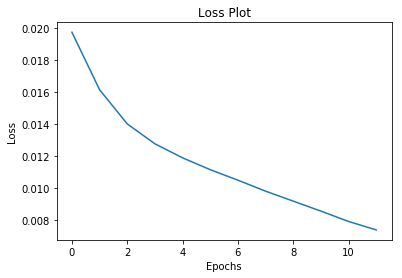

In [24]:
plt.plot(attentionModel.loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [36]:
attentionModel.load_checkpoint()

## 9. Validation Visualise

Real Caption: <start> many sheep are standing in a field next to their young ones <end>
Prediction Caption: several people are standing in the ice orad and jeep cows grazing on a race closely beside some peaked one are lined people moving grazing in a mountain hillside with their backs in a pasture <end>


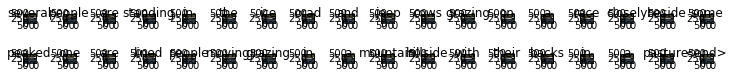

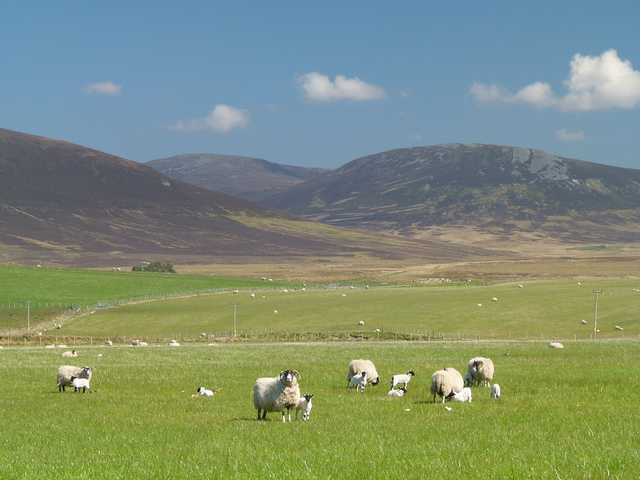

In [51]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
rid = 5
image = img_name_val[rid]
real_caption = ' '.join([tokenisations.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = attentionModel.evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
vis.plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

## 10. Predictions

Prediction Caption: a man on a gentle wave in the ocean <end>


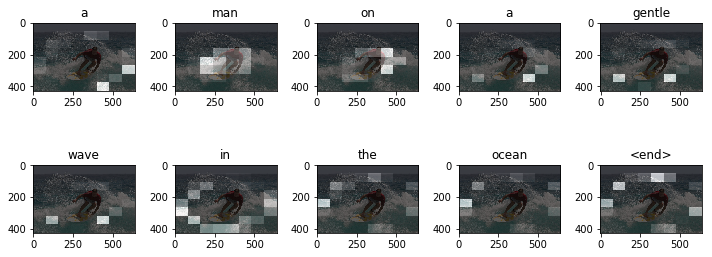

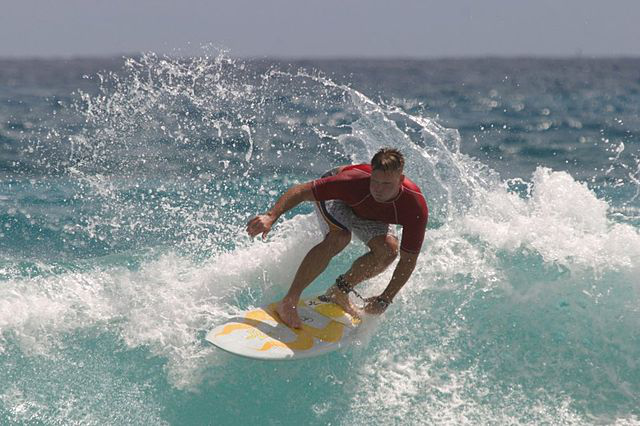

In [50]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, 
                                     origin=image_url)

result, attention_plot = attentionModel.evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
vis.plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)